# Student Name: Saeedreza Zouashkiani
# Student ID: 400206262

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os
from utils import calculate_metrics, count_parameters, train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter('runs/q1/fc')

In [2]:
# initialize the dataset and split into train val and test sets with a ratio of 60:10:30
# transform normalize and resize the images to 150*150
transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root='Shoe vs Sandal vs Boot Dataset', transform=transform)
train_size = int(0.6 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

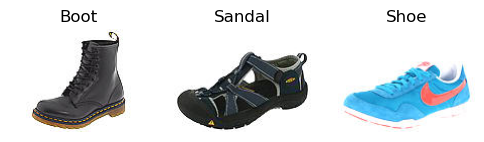

In [3]:
def plot_images(num_images=1, root_dir="Shoe vs Sandal vs Boot Dataset"):
    classes = os.listdir(root_dir)
    plt.figure(figsize=(len(classes) * 2, num_images * 2))
    for i in range(len(classes)):
        for j in range(num_images):
            # get a random image from the class
            img_name = np.random.choice(os.listdir(os.path.join(root_dir, classes[i])))
            img_path = os.path.join(root_dir, classes[i], img_name)
            img = plt.imread(img_path)
            plt.subplot(num_images, len(classes), i * num_images + j + 1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    plt.show()
plot_images()

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for i, linear in enumerate(self.hidden_layers):
            if i != len(self.hidden_layers) - 1:
                x = F.relu(linear(x))
                x = self.dropout(x)
            else:
                x = self.softmax(linear(x))
        return x

In [5]:
hidden_layers = [150 * 150 * 3, 128, 64, 3]
criterion = nn.CrossEntropyLoss()
fc_model = MLP(hidden_layers).to(device)
# add the model to the tensorboard
writer.add_graph(fc_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()

optimizer = optim.Adam(fc_model.parameters(), lr=1e-4)
train_loss, val_loss, train_acc, val_acc = train_model(fc_model, train_loader, val_loader,
                                                       epochs=10, criterion=criterion, optimizer=optimizer,
                                                       writer=writer, device=device, tensorboard=True, verbose=True)
# save the model
torch.save(fc_model.state_dict(), "fc_model.pt")

Epoch: 1/10 	 Train loss: 0.766 	 Train accuracy: 0.786 	 val loss: 0.679 	 val accuracy: 0.871
Epoch: 2/10 	 Train loss: 0.699 	 Train accuracy: 0.850 	 val loss: 0.672 	 val accuracy: 0.879
Epoch: 3/10 	 Train loss: 0.673 	 Train accuracy: 0.878 	 val loss: 0.669 	 val accuracy: 0.880
Epoch: 4/10 	 Train loss: 0.665 	 Train accuracy: 0.888 	 val loss: 0.654 	 val accuracy: 0.895
Epoch: 5/10 	 Train loss: 0.660 	 Train accuracy: 0.890 	 val loss: 0.654 	 val accuracy: 0.893
Epoch: 6/10 	 Train loss: 0.648 	 Train accuracy: 0.905 	 val loss: 0.654 	 val accuracy: 0.894
Epoch: 7/10 	 Train loss: 0.650 	 Train accuracy: 0.901 	 val loss: 0.645 	 val accuracy: 0.905
Epoch: 8/10 	 Train loss: 0.639 	 Train accuracy: 0.914 	 val loss: 0.637 	 val accuracy: 0.914
Epoch: 9/10 	 Train loss: 0.635 	 Train accuracy: 0.917 	 val loss: 0.638 	 val accuracy: 0.914
Epoch: 10/10 	 Train loss: 0.633 	 Train accuracy: 0.919 	 val loss: 0.642 	 val accuracy: 0.913


The model has 8,648,579 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot:		 0.931 		 0.945 		 0.938 		 1527.0
Sandal:		 0.920 		 0.847 		 0.882 		 1466.0
Shoe:		 0.859 		 0.922 		 0.889 		 1507.0
--------------------------------------------------------
Accuracy: 					 0.903 		 4500
Error rate: 					 0.097 		 4500
Macro avg: 	 0.903 		 0.905 		 0.904 		 4500
Weighted avg: 	 0.903 		 0.903 		 2.000 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


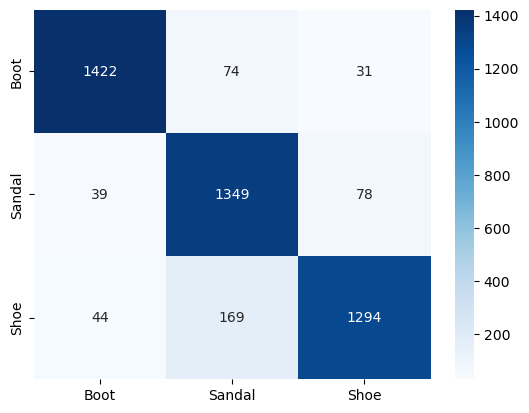

In [6]:
# Metrics for the test set
classes = os.listdir("Shoe vs Sandal vs Boot Dataset")
print(f'The model has {count_parameters(fc_model):,} trainable parameters')    
calculate_metrics(fc_model, test_loader, classes, device=device)

In [7]:
class DropBlock2d(nn.Module):
    """Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2d, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

In [8]:
class CNN(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN, self).__init__()
        self.block_dropout = block_dropout
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
        if self.block_dropout:
            self.dropblock1 = DropBlock2d(0.1, 3)
            self.dropblock2 = DropBlock2d(0.1, 3)
            self.dropblock3 = DropBlock2d(0.1, 3)
            
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.conv1(x))))
        if self.block_dropout:
            x = self.dropblock1(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.conv2(x))))
        if self.block_dropout:
            x = self.dropblock2(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.conv3(x))))
        if self.block_dropout:
            x =  self.dropblock3(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [9]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_dropout")
cnn_model = CNN(block_dropout=False).to(device)
writer.add_graph(cnn_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)

# train the model
train_loss_cnn, val_loss_cnn, train_acc_cnn, val_acc_cnn = train_model(cnn_model, train_loader, val_loader,
                                                                       epochs=10, criterion=criterion, optimizer=optimizer,
                                                                       writer=writer, device=device, tensorboard=True, verbose=True)
# save the model
torch.save(cnn_model.state_dict(), "cnn_model_droput.pt")

Epoch: 1/10 	 Train loss: 0.680 	 Train accuracy: 0.888 	 val loss: 0.854 	 val accuracy: 0.665
Epoch: 2/10 	 Train loss: 0.620 	 Train accuracy: 0.944 	 val loss: 0.822 	 val accuracy: 0.715
Epoch: 3/10 	 Train loss: 0.604 	 Train accuracy: 0.959 	 val loss: 0.709 	 val accuracy: 0.853
Epoch: 4/10 	 Train loss: 0.596 	 Train accuracy: 0.965 	 val loss: 0.678 	 val accuracy: 0.877
Epoch: 5/10 	 Train loss: 0.589 	 Train accuracy: 0.970 	 val loss: 0.635 	 val accuracy: 0.927
Epoch: 6/10 	 Train loss: 0.583 	 Train accuracy: 0.975 	 val loss: 0.636 	 val accuracy: 0.920
Epoch: 7/10 	 Train loss: 0.579 	 Train accuracy: 0.978 	 val loss: 0.630 	 val accuracy: 0.924
Epoch: 8/10 	 Train loss: 0.577 	 Train accuracy: 0.980 	 val loss: 0.634 	 val accuracy: 0.917
Epoch: 9/10 	 Train loss: 0.574 	 Train accuracy: 0.983 	 val loss: 0.633 	 val accuracy: 0.921
Epoch: 10/10 	 Train loss: 0.570 	 Train accuracy: 0.987 	 val loss: 0.611 	 val accuracy: 0.945


The model has 8,320,611 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot:		 0.994 		 0.901 		 0.945 		 1527.0
Sandal:		 0.889 		 0.992 		 0.937 		 1466.0
Shoe:		 0.946 		 0.949 		 0.947 		 1507.0
--------------------------------------------------------
Accuracy: 					 0.944 		 4500
Error rate: 					 0.056 		 4500
Macro avg: 	 0.943 		 0.947 		 0.945 		 4500
Weighted avg: 	 0.944 		 0.944 		 2.000 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


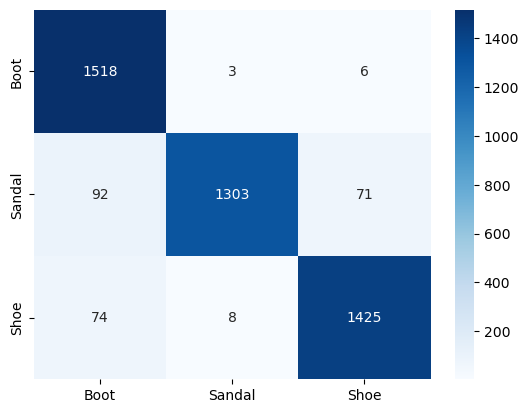

In [10]:
# Metrics for the test set

print(f'The model has {count_parameters(cnn_model):,} trainable parameters')
calculate_metrics(cnn_model, test_loader, classes, device=device)

In [11]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_block_dropout")
cnn_model_dropout = CNN(block_dropout=True).to(device)
writer.add_graph(cnn_model_dropout, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_dropout.parameters(), lr=1e-4)

# train the model
train_loss_cnn_dropout, val_loss_cnn_dropout, train_acc_cnn_dropout, val_acc_cnn_dropout = train_model(cnn_model_dropout, train_loader, val_loader,
                                                                                                       epochs=10, criterion=criterion, optimizer=optimizer, writer=writer,
                                                                                                       device=device, tensorboard=True, verbose=True)
# save the model
torch.save(cnn_model_dropout.state_dict(), "cnn_model_block_dropout.pt")

Epoch: 1/10 	 Train loss: 0.689 	 Train accuracy: 0.877 	 val loss: 0.630 	 val accuracy: 0.938
Epoch: 2/10 	 Train loss: 0.623 	 Train accuracy: 0.942 	 val loss: 0.614 	 val accuracy: 0.944
Epoch: 3/10 	 Train loss: 0.603 	 Train accuracy: 0.960 	 val loss: 0.602 	 val accuracy: 0.955
Epoch: 4/10 	 Train loss: 0.589 	 Train accuracy: 0.973 	 val loss: 0.600 	 val accuracy: 0.954
Epoch: 5/10 	 Train loss: 0.584 	 Train accuracy: 0.976 	 val loss: 0.590 	 val accuracy: 0.961
Epoch: 6/10 	 Train loss: 0.578 	 Train accuracy: 0.981 	 val loss: 0.586 	 val accuracy: 0.967
Epoch: 7/10 	 Train loss: 0.572 	 Train accuracy: 0.986 	 val loss: 0.587 	 val accuracy: 0.967
Epoch: 8/10 	 Train loss: 0.569 	 Train accuracy: 0.988 	 val loss: 0.587 	 val accuracy: 0.969
Epoch: 9/10 	 Train loss: 0.567 	 Train accuracy: 0.989 	 val loss: 0.585 	 val accuracy: 0.968
Epoch: 10/10 	 Train loss: 0.566 	 Train accuracy: 0.989 	 val loss: 0.587 	 val accuracy: 0.970


The model has 8,320,611 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot:		 0.989 		 0.972 		 0.980 		 1527.0
Sandal:		 0.926 		 0.993 		 0.958 		 1466.0
Shoe:		 0.989 		 0.944 		 0.966 		 1507.0
--------------------------------------------------------
Accuracy: 					 0.968 		 4500
Error rate: 					 0.032 		 4500
Macro avg: 	 0.968 		 0.970 		 0.969 		 4500
Weighted avg: 	 0.968 		 0.968 		 2.000 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


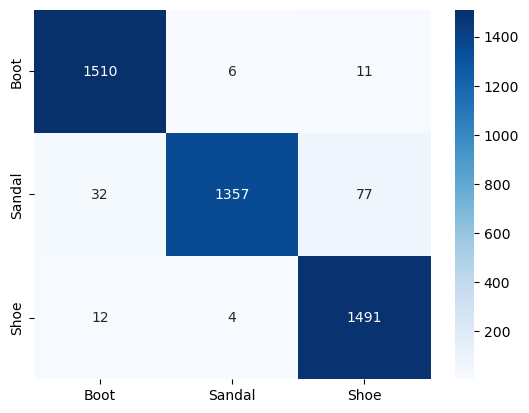

In [12]:
# Metrics for the test set
print(f'The model has {count_parameters(cnn_model_dropout):,} trainable parameters')
calculate_metrics(cnn_model_dropout, test_loader, classes, device=device)

In [13]:
class CNN_factorized(nn.Module):
    def __init__(self, block_dropout=True):
        super(CNN_factorized, self).__init__()
        self.block_dropout = block_dropout
        depth_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3)
        point_conv1 = nn.Conv2d(3, 16, kernel_size=1)
        depth_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, groups=16)
        point_conv2 = nn.Conv2d(16, 32, kernel_size=1)
        depth_conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        point_conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.depthwise_seperable_conv1 = nn.Sequential(depth_conv1, point_conv1)
        self.depthwise_seperable_conv2 = nn.Sequential(depth_conv2, point_conv2)
        self.depthwise_seperable_conv3 = nn.Sequential(depth_conv3, point_conv3)
        self.fc1 = nn.Linear(64 * 18 * 18, 400)
        self.fc2 = nn.Linear(400, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm1d(400)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
        if self.block_dropout:
            self.dropblock1 = DropBlock2d(0.2, 3) 
            self.dropblock2 = DropBlock2d(0.2, 3)
            self.dropblock3 = DropBlock2d(0.2, 3)
    def forward(self, x):
        x = self.maxpool(F.relu(self.batchnorm1(self.depthwise_seperable_conv1(x))))
        if self.block_dropout:
            x = self.dropblock1(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm2(self.depthwise_seperable_conv2(x))))
        if self.block_dropout:
            x = self.dropblock2(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = self.maxpool(F.relu(self.batchnorm3(self.depthwise_seperable_conv3(x))))
        if self.block_dropout:
            x = self.dropblock3(x)
        else:
            x = F.dropout(x, 0.2, training=self.training)
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.batchnorm4(self.fc1(x)))
        x = F.dropout(x, 0.2, training=self.training)
        x = self.softmax(self.fc2(x))
        return x

In [14]:
# initialize the model and move it to GPU and add to tensorboard
writer = SummaryWriter("runs/q1/cnn_factorized")
cnn_model_factorized = CNN_factorized().to(device)
writer.add_graph(cnn_model_factorized, torch.rand(1, 3, 150, 150).to(device))
writer.close()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_factorized.parameters(), lr=1e-4)

# train the model
cnn_factorized_train_losses, cnn_factorized_train_acc, cnn_factorized_val_losses, cnn_factorized_val_acc = train_model(cnn_model_factorized, train_loader, val_loader,
                                                                                                                       epochs=10, criterion=criterion, optimizer=optimizer, writer=writer,
                                                                                                                       device=device, tensorboard=True, verbose=True)
# save the model
torch.save(cnn_model_factorized.state_dict(), "cnn_model__factorized.pt")

Epoch: 1/10 	 Train loss: 0.721 	 Train accuracy: 0.846 	 val loss: 0.690 	 val accuracy: 0.883
Epoch: 2/10 	 Train loss: 0.663 	 Train accuracy: 0.905 	 val loss: 0.663 	 val accuracy: 0.905
Epoch: 3/10 	 Train loss: 0.639 	 Train accuracy: 0.926 	 val loss: 0.654 	 val accuracy: 0.907
Epoch: 4/10 	 Train loss: 0.627 	 Train accuracy: 0.936 	 val loss: 0.648 	 val accuracy: 0.911
Epoch: 5/10 	 Train loss: 0.621 	 Train accuracy: 0.939 	 val loss: 0.637 	 val accuracy: 0.922
Epoch: 6/10 	 Train loss: 0.614 	 Train accuracy: 0.947 	 val loss: 0.627 	 val accuracy: 0.933
Epoch: 7/10 	 Train loss: 0.607 	 Train accuracy: 0.952 	 val loss: 0.618 	 val accuracy: 0.937
Epoch: 8/10 	 Train loss: 0.605 	 Train accuracy: 0.955 	 val loss: 0.604 	 val accuracy: 0.954
Epoch: 9/10 	 Train loss: 0.600 	 Train accuracy: 0.960 	 val loss: 0.612 	 val accuracy: 0.943
Epoch: 10/10 	 Train loss: 0.597 	 Train accuracy: 0.960 	 val loss: 0.607 	 val accuracy: 0.949


The model has 8,300,257 trainable parameters
------------------Classification Report------------------
		 precision 	 recall 	 f1-score 	 support
Boot:		 0.986 		 0.940 		 0.962 		 1527.0
Sandal:		 0.920 		 0.976 		 0.947 		 1466.0
Shoe:		 0.954 		 0.947 		 0.951 		 1507.0
--------------------------------------------------------
Accuracy: 					 0.954 		 4500
Error rate: 					 0.046 		 4500
Macro avg: 	 0.953 		 0.954 		 0.954 		 4500
Weighted avg: 	 0.954 		 0.954 		 2.000 		 4500
--------------------------------------------------------



------------------Confusion Matrix------------------


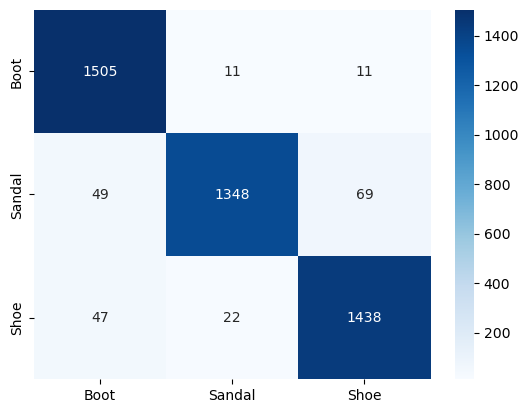

In [15]:
# Metrics for the test set
print(f'The model has {count_parameters(cnn_model_factorized):,} trainable parameters')
calculate_metrics(cnn_model_factorized, test_loader, classes, device=device)

# Tensorboard results

![Tensorboard](https://github.com/saeedzou/DeepLearning1401-01/blob/dev/Assignment%203/Figures/Tensorboard.png)

As described in the paper Efficient Object Localization Using Convolutional Networks , if adjacent pixels within feature maps are strongly correlated (as is normally the case in early convolution layers) then i.i.d. dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease.